In [1]:
import sionna.rt
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from tqdm import tqdm
import os
from sionna.rt import load_scene, AntennaArray, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies
from utils import ituf_glass_callback, ituf_concrete_callback, ituf_metal_callback, \
                  ituf_polystyrene_callback, ituf_mdf_callback, load_config, create_folder
from ue_locations_generator import create_user_location_dataset
import logging
import datetime
%matplotlib inline



2025-07-10 12:50:17.976619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752151817.998186 1558716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752151818.004735 1558716 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752151818.022839 1558716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752151818.022857 1558716 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752151818.022859 1558716 computation_placer.cc:177] computation placer alr

In [2]:

def setup():
    # check versions and set up GPU
    logger.info(f"Sionna version: {sionna.rt.__version__}" )
    logger.info("ftf version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    logger.info("GPU:", gpus)
    if gpus:
        # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU') # only use the first GPU
            logical_gpus = tf.config.list_logical_devices('GPU')
            logger.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
            logger.info("Using GPU:", gpus[0].name)
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            logger.info(e)
    else:
        logger.info("No GPU found, using CPU.")

def set_materials(scene, config):
    # check which materials are available in the scene
    logger.info("Available materials:")
    for name, obj in scene.objects.items():
        logger.info(f'{name:<15}{obj.radio_material.name}')

    # set materials for the scene
    # add callbacks to the materials
    logger.info("radio materials with associated callbacks:")
    # Ceiling_Detail => polystyrene
    ceiling_object = scene.get("Ceiling_Detail")
    ceiling_object.radio_material.frequency_update_callback = ituf_polystyrene_callback
    logger.info(ceiling_object.radio_material.name)
    logger.info(ceiling_object.radio_material.frequency_update_callback)

    # no-name-1 => ituf_glass
    glass_objects = scene.get("no-name-1")
    glass_objects.radio_material.frequency_update_callback = ituf_glass_callback
    logger.info(glass_objects.radio_material.name)
    logger.info(glass_objects.radio_material.frequency_update_callback)

    # no-name-2 => ituf_concrete
    concrete_objects = scene.get("no-name-2")
    concrete_objects.radio_material.frequency_update_callback = ituf_concrete_callback
    logger.info(concrete_objects.radio_material.name)
    logger.info(concrete_objects.radio_material.frequency_update_callback)

    # no-name-3 => ituf_metal
    metal_objects = scene.get("no-name-3")
    metal_objects.radio_material.frequency_update_callback = ituf_metal_callback
    logger.info(metal_objects.radio_material.name)
    logger.info(metal_objects.radio_material.frequency_update_callback)

    # no-name-4 => ituf_mdf
    metal_mdf = scene.get("no-name-4")
    metal_mdf.radio_material.frequency_update_callback = ituf_mdf_callback
    logger.info(metal_mdf.radio_material.name)
    logger.info(metal_mdf.radio_material.frequency_update_callback)

    # check conductivity and relative permittivity at different frequencies
    # loop through material names and print them
    sub_GHz = config['sub10GHz_config']['fc']
    sub_THz = config['subTHz_config']['fc']
    logger.info(f"Checking materials at {sub_GHz/1e9} GHz and {sub_THz/1e9} GHz")
    for key, value in scene.objects.items():
        logger.info(f'---------------{key=}----------------')
        # Print name of assigned radio material for different frequenies
        for f in [sub_GHz, sub_THz]: # Print for differrent frequencies
            scene.frequency = f
            value.radio_material.frequency_update() # update the frequency of the objects
            logger.info(f"\nRadioMaterial: {value.radio_material.name} at {scene.frequency/1e9} GHz")
            logger.info(f"Conductivity: {value.radio_material.conductivity.numpy()}")
            logger.info(f"Relative permittivity: {value.radio_material.relative_permittivity.numpy()}")
            logger.info(f"Scattering coefficient: {value.radio_material.scattering_coefficient.numpy()}")
            logger.info(f"XPD coefficient: {value.radio_material.xpd_coefficient.numpy()}")


2025-07-10 12:50:20,975 - INFO - Sionna version: 1.0.2
2025-07-10 12:50:20,976 - INFO - ftf version: {tf.__version__}
--- Logging error ---
Traceback (most recent call last):
  File "/home/user/.pyenv/versions/3.11.12/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/user/.pyenv/versions/3.11.12/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/user/.pyenv/versions/3.11.12/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/user/.pyenv/versions/3.11.12/lib/python3.11/logging/__init__.py", line 377, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, 

Folder already exists: /home/user/6GTandem_RT_server/dataset_5681_ue_locations/ue_locations
Folder already exists: /home/user/6GTandem_RT_server/debugging/sub_thz_channels


2025-07-10 12:50:21 WARN wrk0 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

2025-07-10 12:50:21,520 - INFO - Available materials:
2025-07-10 12:50:21,521 - INFO - no-name-1      ituf_glass
2025-07-10 12:50:21,522 - INFO - no-name-2      ituf_metal
2025-07-10 12:50:21,522 - INFO - Ceiling_Detail ituf_polystyrene
2025-07-10 12:50:21,523 - INFO - no-name-3      ituf_concrete
2025-07-10 12:50:21,523 - INFO - no-name-4      ituf_mdf
2025-07-10 12:50:21,524 - INFO - radio materials with associated callbacks:
2025-07-10 12:50:21,525 - INFO - ituf_polystyrene
2025-07-10 12:50:21,525 - INFO - <function ituf_polystyrene_callback at 0x71ecebe5f100>
2025-07-10 12:50:21,526 - INFO - ituf_glass
2025-07-10 12:50:21,527 - INFO - <function ituf_glass_callback at 0x71ecebfedbc0>
2025-07-10 12:50:21,527 - INFO - ituf_metal
2025-07-10 12:50:21,528 - INFO - <function ituf_concrete_callback at 0x71ecebfee200>
2025-07-10 12:50:21,529 - INFO - ituf_concrete
2025-07-10 12:50:21,529 - INFO - <function ituf_metal_callback at 0x71ecebfedd00>
2025-07-10 12:50:21,530 - INFO - ituf_mdf
2025

z coordinate: 1.5
RX orientation pre look at: [[0, 0, 0]]


TypeError: Invalid shape (4, 2, 1024) for image data

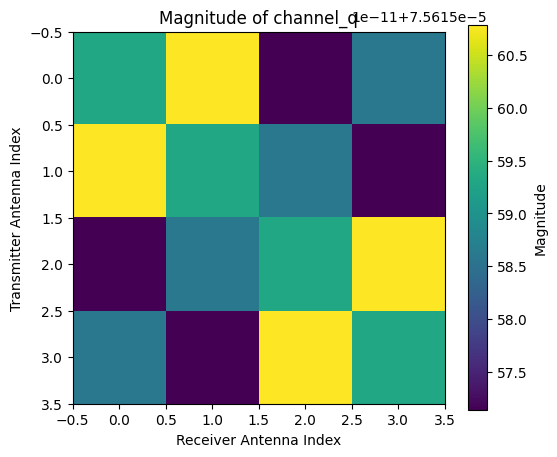

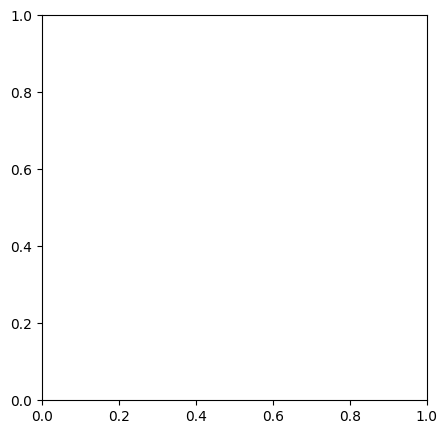

In [ ]:
from sionna.rt.antenna_pattern import register_polarization
import drjit as dr


# Configure logging
log_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"run_{log_time}.log"
logging.basicConfig(
    filename=log_filename,              # Log file name
    filemode='a',                    # Append mode
    level=logging.INFO,              # Set to DEBUG for more verbosity
    format='%(asctime)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

# also see logs in the console
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
logger = logging.getLogger()
logger.addHandler(console_handler)

# check versions and set up GPU
setup()

# load config file
config = load_config()

# create or load user dataset
ds_users, dataset_path = create_user_location_dataset(config, logger)

# set output path
channel_output_path = os.path.join(r'/home/user/6GTandem_RT_server/debugging', 'sub_thz_channels')
create_folder(channel_output_path)

# load params from config file
intermediate_reders = config['random_configs']['intermediate_renders'] # slows down the program a lot => only for debugging!!!

# load scene# Load scene
scene = load_scene(config['paths']['scenepath']) 

# preview scene 
# Create new camera with different configuration
my_cam = Camera(position=[9,35,0.5], look_at=[0,0,3])

# Render scene with new camera
if intermediate_reders:
    scene.render_to_file(camera=my_cam, filename='empty_scene.png', resolution=[650, 500], num_samples=512, clip_at=20) # Increase num_samples to increase image quality

# set materials for the scene
set_materials(scene, config)

# configure tx and rx arrays
N_antennas = config['antenna_config']['N_antennas_per_axis']
logger.info(f'number antennas per axis: {N_antennas}')

register_polarization("cross_1", [-dr.pi/4])
register_polarization("cross_2", [dr.pi/4])


scene.tx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=config['antenna_config']['pattern'],
                            polarization='H')#config['antenna_config']['polarization'])

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=N_antennas,
                            num_cols=N_antennas,
                            vertical_spacing=0.5,
                            horizontal_spacing=0.5,
                            pattern=config['antenna_config']['pattern'],
                            polarization='H')


# sub-THz stripe specs 
stripe_start_pos = config['stripe_config']['stripe_start_pos']
N_RUs = config['stripe_config']['N_RUs'] # adjust to size of the room (along y axis)
N_stripes = config['stripe_config']['N_stripes']# adjust to size of the room (alang x axis)
total_N_RUs = N_RUs * N_stripes # total number of radio units
space_between_RUs = config['stripe_config']['space_between_RUs'] # in meters
space_between_stripses = config['stripe_config']['space_between_stripes'] # in meters

# OFDM system parameters
BW = config['subTHz_config']['bw'] # Bandwidth of the system
num_subcarriers = config['subTHz_config']['num_subcarriers']
logger.info(f'bw type: {type(BW)}')
logger.info(f'bw type: {type(num_subcarriers)}')

subcarrier_spacing = BW / num_subcarriers
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing) # Compute baseband frequencies of subcarriers relative to the carrier frequency
logger.info(f'subcarrier spacing = {subcarrier_spacing/1e6} MHz')

# set scene frequency
scene.frequency = config['subTHz_config']['fc']# Set frequency to fc 
logger.info(f"scene frequency set to: {scene.frequency}")

# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()
logger.info(f'path solver loop mode: {p_solver.loop_mode}') #symbolic mode is the fastest! 

# loop over al ue postions
for ue_idx in range(ds_users.dims['user']):
    # output file location
    out_file = os.path.join(channel_output_path, f"channels_thz_ue_{ue_idx}.nc")
    if os.path.exists(out_file):
        logger.info(f"User {ue_idx} already processed. Skipping.")
        continue
    if ds_users.invalid_point.values[ue_idx]:
        logger.info(f'User {ue_idx} is at an invalid location (within an object) and will not be processed. Skipping.')
        continue

    logger.info(f"Processing user {ue_idx}/{ds_users.dims['user']}...")

    # get coordinates
    x, y, z = ds_users.x.values[ue_idx], ds_users.y.values[ue_idx], ds_users.z.values[ue_idx]
    print(f'z coordinate: {z}') # check z coordinate
    ue_pos = [float(2), float(2.5), float(z)]#[float(x), float(y), float(z)]

    # Create a receiver
    rx = Receiver(name=f"rx_{ue_idx}",
                position=ue_pos,
                display_radius=0.5)
    
    print(f'RX orientation pre look at: {rx.orientation}') # check orientation
    
    # Point the receiver upwards
    rx.look_at([ue_pos[0], ue_pos[1], 3.5]) # Receiver points upwards
    # scene.rx_array.show()

    # scene.rx_array.antenna_pattern.show()

    # print(f'RX orientation post look at: {rx.orientation}') # check orientation


    # check orientation
    #print(f'rx orientation: {rx.orientation}')

    # Add receiver instance to scene
    scene.add(rx)

    # Preallocate channel tensor and index arrays (2x N^2 because cross polarization)
    channel_tensor = np.empty(
        (total_N_RUs, 2*N_antennas**2, 2*N_antennas**2, num_subcarriers),
        dtype=np.complex64
    )
    stripe_idx_arr = np.empty(total_N_RUs, dtype=np.int32)
    ru_idx_arr = np.empty(total_N_RUs, dtype=np.int32)

    tx_idx = 0

    # start time current ue computation
    t_start_ue = time.time()

    # loop over all stripes
    for stripe_idx in range(N_stripes):
        # start time 1 stripe computation
        #t1 = time.time()
        # log
        #logger.info(f"Processing UE {ue_idx}/{ds_users.dims['user']} stripe {stripe_idx} ...")
        # loop over all RUs 
        for RU_idx in range(N_RUs):
            
            # compute RU position
            tx_pos = [stripe_start_pos[0] + stripe_idx * space_between_stripses,
                    stripe_start_pos[1] + RU_idx * space_between_RUs,
                    stripe_start_pos[2]]
            
            # Create RU transmitter instance
            tx = Transmitter(name=f"tx_stripe_{stripe_idx}_RU_{RU_idx}",
                        position=tx_pos,
                        display_radius=0.1)

            # Add RU transmitter instance to scene
            scene.add(tx)

            # Point the transmitter downwards
            tx.look_at([tx_pos[0], tx_pos[1], 0]) # Transmitter points downwards

            # scene.tx_array.show()

            # scene.tx_array.antenna_pattern.show()

            # print(f'TX orientation post look at: {tx.orientation}') # check orientation

            # check orientation
            #print(f'tx orientation: {tx.orientation}')

            # render scene with tx and rx
            if intermediate_reders:
                logger.info(f' rendering scene prior to path solver')
                scene.render_to_file(camera=my_cam, filename=f'scene_with_stripe_{stripe_idx}_RU_{RU_idx}.png', 
                                    resolution=[650, 500], num_samples=512, clip_at=20) 



            # todo recheck this
            paths = p_solver(scene=scene,
                            max_depth=0,
                            los=True,
                            specular_reflection=True,
                            diffuse_reflection=False, # no scattering
                            refraction=True,
                            synthetic_array=False,
                            seed=41)

            # Compute channel frequency response
            # Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
            # note that because of cross polarization we get 2*num_rx_ant and 2*num_tx_ant
            # todo to be checked: structured as [ant_1_pol_1, ant_1_pol_2, ant_2_pol_1, ant_2_pol_2, ..., ant_N_pol_2]
            h_freq = paths.cfr(frequencies=frequencies,
                            normalize_delays=True,
                            out_type="numpy")
            #print("Shape of h_freq: ", h_freq.shape)

            # todo check shapes
            # reshape to [2*nr_rx_antennas, 2*nr_tx_antennas, nr_subcarriers]
            h_freq = np.squeeze(h_freq)
            #print("Shape of h_freq post squeeze: ", h_freq.shape)

            mag_hfreq = np.abs(h_freq[:, :, 0])  # Magnitude of the channel frequency response
            plt.figure(figsize=(6, 5))
            plt.imshow(mag_hfreq, cmap='viridis', interpolation='nearest')
            plt.title('Magnitude of channel_q')
            plt.colorbar(label='Magnitude')
            plt.xlabel('Receiver Antenna Index')
            plt.ylabel('Transmitter Antenna Index')
            plt.grid(False)
            # Save to file
            plt.show

            
    break
